# Deep Learning for Malaria Diagnosis
**Author:** [Dr. Habiboulaye Amadou-Boubacar](https://www.linkedin.com/in/habiboulaye-amadou-boubacar-8b153710)  
This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018) and (Jason Brownlee, 2019). Acknowledge to NIH and Bangalor Hospital who make available this malaria dataset.

Malaria is an infectuous disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes.

The Malaria burden with some key figures:
<font color='red'>
* More than 219 million cases
* Over 430 000 deaths in 2017 (Mostly: children & pregnants)
* 80% in 15 countries of Africa & India
  </font>

![MalariaBurd](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaBurden.png?raw=1)

The malaria diagnosis is performed using blood test:
* Collect patient blood smear 
* Microscopic visualisation of the parasit

![MalariaDiag](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaDiag.png?raw=1)
  
Main issues related to traditional diagnosis: 
<font color='#ed7d31'>
* resource-constrained regions 
* time needed and delays
* diagnosis accuracy and cost
</font>

The objective of this notebook is to apply modern deep learning techniques to perform medical image analysis for malaria diagnosis.

*This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018), (Adrian Rosebrock, 2018) and (Jason Brownlee, 2019)*

## Configuration

* **Useful infos**: *https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d*

In [0]:
#Mount the local drive project_forder
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"

In [0]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

## Populating namespaces

In [0]:
# Importing basic libraries
import os
import random
import shutil
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline

# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D as Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [0]:
# Define the useful paths for data accessibility
ai_project = '.' #"/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
cell_images_dir = os.path.join(ai_project,'cell_images')
training_path = os.path.join(ai_project,'train')
testing_path = os.path.join(ai_project,'test')

## Prepare DataSet

### *Download* DataSet

In [0]:
# Download the data in the allocated google cloud-server. If already down, turn downloadData=False
downloadData = True
if downloadData == True:
  indrive = False
  if indrive == True:
    !wget https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip -P "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
    !unzip "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images.zip" -d "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/"
    !ls "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
  else: #incloud google server
    !rm -rf cell_images.*
    !wget https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
    !unzip cell_images.zip >/dev/null 2>&1
    !ls 

### Visualize cell images

In [0]:
# Visualize some samples (randomly selected) of blood smears from healthy patients 
N_samples = 6
uninfected_dir = os.path.join(cell_images_dir,'Uninfected')
uninfected_samples = random.sample(os.listdir(uninfected_dir), N_samples)
pyplot.figure(figsize=(15,3))
print("{} Uninfected images: view of {} samples".format(len(os.listdir(uninfected_dir)), N_samples))
i = 0
while i < N_samples: # in random.sample(os.listdir(parasitized_dir), 6):
    pyplot.subplot(1,N_samples,1+i)
    img_uninfected = imread(os.path.join(uninfected_dir, uninfected_samples[i]))
    pyplot.imshow(img_uninfected)
    i+=1
print(img_uninfected.shape)

<font color='red'>
EXERCICE: Similarly, display some samples (randomly selected) of infected blood smears by replacing all <FILL_IN> with the correct codes
 </font>

In [0]:
# Visualize some samples (randomly selected) of blood smears from patients falciparum-infected 
print("{} Parasitized images: view of {} samples".format(len(os.listdir(uninfected_dir)), N_samples))
parasitized_dir = os.path.join(cell_images_dir,'Parasitized')
<FILL_IN>
pyplot.figure(figsize=(15,3))
i = 0
while i < N_samples: # in random.sample(os.listdir(parasitized_dir), 6):
    pyplot.subplot(1,N_samples,1+i)
    #Not Implemented
    <FILL_IN>
    <FILL_IN>
    i+=1
print(img_parasitized.shape)

### Split train-test

In [0]:
def create_train_test_data(class_name, train_split = 0.8):
    '''
      #Create a function create_train_test_data to split data into 
      #training and testing sets with respectives proportion 80%, 20%
      #--Train (@training_path)
          #--Parasitized
          #--Uninfected
      #--Test (@training_path)
          #--Parasitized
          #--Uninfected
      @class_name: 'Parasitized' or 'Uninfected'
      @train_split: eg. 80% train 20% test
    '''    
    train_class_path = os.path.join(training_path,class_name)  
    test_class_path = os.path.join(testing_path,class_name)

    class_img_names = [img for img in os.listdir(os.path.join(cell_images_dir, class_name))]
    random.seed(42)
    random.shuffle(class_img_names)

    # compute the training and testing split
    i = int(len(class_img_names) * train_split)
    train_class_img_names = class_img_names[:i]
    test_class_img_names = class_img_names[i:]

    def copy_imgs(learn_class_img_names, learn_class_path):
        if not os.path.exists(learn_class_path):
            os.makedirs(learn_class_path)
        for img in learn_class_img_names:
            p_orig = os.path.join(cell_images_dir,class_name,img) 
            p_dest = os.path.join(learn_class_path,img) 
            shutil.copy2(p_orig, p_dest)

    copy_imgs(train_class_img_names, train_class_path)
    copy_imgs(test_class_img_names, test_class_path)

SplitTrainTest = True
if SplitTrainTest == True:
    #Not Implemented
    if os.path.exists(training_path): shutil.rmtree(training_path)
    if os.path.exists(testing_path): shutil.rmtree(testing_path)
    <FILL IN> # Create the training and testing subset for Parasitized class by using function create_train_test_data
    <FILL IN> # Create the training and testing subset for Uninfected class by using function create_train_test_data
!ls train/ test/  # Check if training_path and testing_path folders with both classes are created
!ls train/Parasitized | wc -l

## Baseline CNN Model
Define a basic ConvNet defined with ConvLayer: Conv2D => MaxPooling2D followed by Flatten => Dense => Dense(output)

![ConvNet](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/ConvNet.png?raw=1)


In [0]:
#single convolutional layer with 32 filters followed by a max pooling layer.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
BatchSize = 32
xy_shape = 64
n_epochs = 20

<font color='red'>
EXERCICE: Replace the <FILL_IN> with the correct codes to complete the 1-layer convolutional neural architecture
 </font>

In [0]:
# define cnn model
def simple_cnn_model():
    model = Sequential()
    # 1 ConvLayer
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(xy_shape, xy_shape, 3)))
    model.add(MaxPooling2D((2, 2)))
    # Flatten and Dense layers
    model.add(Flatten())
    # Add a Dense (Fully Connected) layer with 128 neurons with 'relu' activation with a kernel_initializer='he_uniform'
    <FILL_IN>
    # Add a Dense output layer with 1 neurons with 'sigmoid' activation
    <FILL_IN>
    # compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [0]:
# Instanciate a data generator to fit the model
dataGen = ImageDataGenerator(rescale=1.0/255.0)
# prepare iterators
train_gen = dataGen.flow_from_directory(training_path,class_mode="binary",target_size=(xy_shape, xy_shape),
                                         batch_size=BatchSize)
test_gen = dataGen.flow_from_directory(testing_path,class_mode="binary",target_size=(xy_shape, xy_shape),
                                        batch_size=BatchSize)

In [0]:
# Instanciate and train the model
conv_net1 = simple_cnn_model()
conv_net1_loss_acc_records = conv_net1.fit_generator(train_gen, steps_per_epoch=len(train_gen),validation_data=test_gen, validation_steps=len(test_gen), 
                              epochs=n_epochs, verbose=1, use_multiprocessing=True)#, workers=) #validation_freq=[1,2,5,10,15,20],

In [0]:
# This function is defined to visualise loss and accuracy
def assess_performance(history):
    pyplot.figure(figsize=(15,3))
    # plot loss
    pyplot.subplot(121)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(122)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['acc'], color='blue', label='train')
    pyplot.plot(history.history['val_acc'], color='orange', label='test')

assess_performance(conv_net1_loss_acc_records)

In [0]:
# evaluate model
_, acc = conv_net1.evaluate_generator(test_gen, steps=len(test_gen), use_multiprocessing=True, verbose=0)
print('> %.3f' % (acc * 100.0))

### Data Augmentation

<font color='red'>
EXERCICE: Replace the <FILL_IN> with the correct codes to generate new augmented data
 </font>

In [0]:
# Use data augmentation techniques to generate more variational data and improve the performance
# data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.
# Training deep learning neural network models on more data can result in more skillful models, and the augmentation techniques can create variations of the images that can improve the ability of the fit models to generalize what they have learned to new images.
# the training dataset will be augmented with small (10%) random horizontal and vertical shifts and random horizontal flips that create a mirror image of a photo. Photos in both the train and test steps will have their pixel values scaled in the same way.

trainAug = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest")
# Keep
# dataGen = ImageDataGenerator(rescale=1.0/255.0)

# Generate the new training data using augmentation and testing data 
train_aug = <Fill_IN>
test_gen = <Fill_IN>

In [0]:
# Train the model with augmented data and assess the performance
conv_net1_aug = simple_cnn_model()
conv_net1_aug_loss_acc_records = conv_net1_aug.fit_generator(train_aug, steps_per_epoch=len(train_aug),validation_data=test_gen, validation_steps=len(test_gen), 
                              epochs=n_epochs, verbose=1, use_multiprocessing=True, workers=2) #validation_freq=[1,2,5,10,15,20],

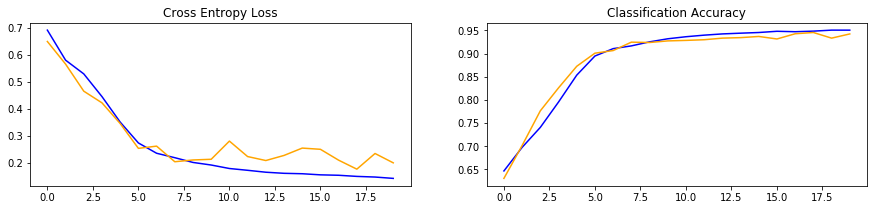

In [0]:
# Plot loss and accurate and conclude
assess_performance(conv_net1_aug_loss_acc_records)

In [0]:
# evaluate model
_, acc = conv_net1_aug.evaluate_generator(test_gen, steps=len(test_gen), use_multiprocessing=True, verbose=0)
print('> %.3f' % (acc * 100.0))

## 2-ConvLayers CNN

<font color='red'>
EXERCICE: Create a CNN with 2 ConvLayers by replacing all the <FILL_IN> with the correct codes
 </font>

In [0]:
def cnn_model():
    '''
      Create the 2 layers ConvNet: FirstConvLayer > FirstConvLayer > Flatten > Dense > Dense(output)
    '''
    # Not Implemmented
    model = Sequential()
    # First ConvLayer: use-ing 32 3x3-filters, 'relu' activation function, kernel_initializer='he_uniform', padding='same' with the correct input shape
    <FILL_IN> #Conv2D with above listed parameters
    <FILL_IN> #MaxPooling2D with shape 2x2
    # Second ConvLayer: use-ing 32 3x3-filters, 'relu' activation function
    <FILL_IN> #Conv2D with above listed parameters
    <FILL_IN> #MaxPooling2D with shape 2x2
    # Flatten followed by Dense and sigmoid Ouput Layers
    <FILL_IN> # Flatten
    <FILL_IN> # Dense with 128 neurones, activation='relu', kernel_initializer='he_uniform'
    <FILL_IN> # Dense with 1 neuron activate by 'sigmoid' function
    # compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [0]:
conv_net2_aug = cnn_model()
conv_net2_aug_loss_acc_records = conv_net2_aug.fit_generator(train_aug, steps_per_epoch=len(train_aug),validation_data=test_gen, validation_steps=len(test_gen), 
                              epochs=n_epochs, verbose=1, use_multiprocessing=True, workers=2) #validation_freq=[1,2,5,10,15,20],

In [0]:
assess_performance(conv_net2_aug_loss_acc_records)

In [0]:
# evaluate model
_, acc = conv_net2_aug.evaluate_generator(test_gen, steps=len(test_gen), use_multiprocessing=True, verbose=0)
print('> %.3f' % (acc * 100.0))

## Prediction: Automatic AI-based malaria diagnosis

In [0]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
# load and prepare the image
def load_image(filename, xy_shape=xy_shape):
    # load the image
    img = load_img(filename, target_size=(xy_shape, xy_shape))
    pyplot.imshow(img)
    # convert to array
    img = img_to_array(img)
    #print(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, xy_shape, xy_shape, 3)
    # center pixel data
    img = img.astype('float32')/255
    #img = img - [123.68, 116.779, 103.939]
    return img

In [0]:
#!cp /content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/physician_questions/patient_1.png .
!wget https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/physician_questions/patient_1.png
p_ask_image = 'patient_1.png' #os.path.join('physician_questions', 'patient_4.png')
image = load_image(p_ask_image)
pred_prod = conv_net2_aug.predict(image)[0][0]
print('Prediction: {:.2%} => {}'.format(pred_prod, 'Uninfected' if pred_prod > 0.5 else 'Parasitized'))

## Transfer Learning

In [0]:
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
# define cnn model
xy_shape3 = 224
BatchSize3 = 64
def deep_cnn_transfer_model():
    model = VGG16(include_top=False, input_shape=(xy_shape3, xy_shape3, 3))
    # mark loaded layers as not trainable
    nb_layers = len(model.layers)
    print('nb_layers:',nb_layers)
    for layer in model.layers: #[:nb_layers-5]:  #model.layers[1:20]
        layer.trainable=False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    #opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [0]:
conv_deep_transfer = deep_cnn_transfer_model()
conv_deep_transfer.summary()

In [0]:
train_aug = trainAug.flow_from_directory(training_path,class_mode="binary",target_size=(xy_shape3, xy_shape3),
                                         batch_size=BatchSize3)
test_gen = dataGen.flow_from_directory(testing_path,class_mode="binary",target_size=(xy_shape3, xy_shape3),
                                        batch_size=BatchSize3)

In [0]:
conv_deep_transfer_loss_acc_records = conv_deep_transfer.fit_generator(train_aug, steps_per_epoch=len(train_aug),validation_data=test_gen, validation_steps=len(test_gen), 
                              epochs=n_epochs, verbose=1, use_multiprocessing=True, workers=2) #validation_freq=[1,2,5,10,15,20],

In [0]:
assess_performance(conv_deep_transfer_loss_acc_records)

In [0]:
# evaluate model
_, acc = conv_deep_transfer.evaluate_generator(test_gen, steps=len(test_gen), use_multiprocessing=True, verbose=0)
print('> %.3f' % (acc * 100.0))

## Compare performance results

*   conv_net1: 
*   conv_net1_aug
*   conv_net2_aug:
*   conv_deep_transfer:

***Conclusion:***